In [3]:
import sys
import os
import json
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm, ListedColormap
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage

In [4]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

## Stem plots of feature importance (normalized between 0 and 1) for each of the models
## Rank the top 10 or 20 features by the best performing method (OLS) 
### Within each feature, separate into 4 stem lines, one for each model

### Models to use:
    1. OLS
    2. LASSO 
    3. PLS
    4. RF
    5. Individual linear regression 
        - A scaled feature importance can be derived from the -log10(q-value) for each Fed & Fasted fit 
    - Skip SVM and Ridge because within our data they are identical to OLS

In [6]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
r = r.loc[(r['y'] == 'ogtt') & (r['model'].isin(['ols', 'lasso', 'pls', 'rf']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
r = r[cols]
r['i'] = r['model'] + '_' + r['x']
new_cols = r['i']
r = r.drop(['model', 'x'], axis=1)
r = r.set_index('i').T.abs()
# r = r.loc[data['ID'] != 'unknown']  # only use IDs
# r = r.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
r.loc[:, :] = MinMaxScaler().fit_transform(r)  # perform 0 to 1 scaling of absolute value of coefficients
r = r.join(data)
r = r.sort_values('ols_Fed', ascending=False)  # .iloc[:20]
r['y_point'] = range(len(r))  # range(len(r), 0, -1)
r['is_id'] = r['ID'] != 'unknown'
r['avg_Fed'] = r.filter(regex='_Fed').mean(axis=1)
r['avg_Fasted'] = r.filter(regex='_Fasted').mean(axis=1)
r

KeyError: "['m_8', 'm_13', 'm_14', 'm_15', 'm_21', 'm_35', 'm_36', 'm_37', 'm_38', 'm_42', 'm_62', 'm_63', 'm_64', 'm_65', 'm_66', 'm_67', 'm_68', 'm_69', 'm_70', 'm_71', 'm_72', 'm_73', 'm_74', 'm_75', 'm_76', 'm_77', 'm_78', 'm_80', 'm_82', 'm_83', 'm_84', 'm_85', 'm_86', 'm_87', 'm_88', 'm_89', 'm_90', 'm_91', 'm_92', 'm_93', 'm_94', 'm_95', 'm_96', 'm_126', 'm_127', 'm_128', 'm_129', 'm_130', 'm_131', 'm_132', 'm_133', 'm_134', 'm_135', 'm_136', 'm_137', 'm_138', 'm_139', 'm_140', 'm_141', 'm_142', 'm_143', 'm_144', 'm_145', 'm_146', 'm_147', 'm_148', 'm_149', 'm_150', 'm_151', 'm_152', 'm_153', 'm_154', 'm_155', 'm_156', 'm_157', 'm_158', 'm_159', 'm_160', 'm_161', 'm_162', 'm_163', 'm_164', 'm_165', 'm_166', 'm_167', 'm_168', 'm_169', 'm_170', 'm_171', 'm_172', 'm_173', 'm_174', 'm_175', 'm_176', 'm_177', 'm_178', 'm_179', 'm_180', 'm_181', 'm_182', 'm_183', 'm_184', 'm_185', 'm_186', 'm_187', 'm_188', 'm_189', 'm_190', 'm_208', 'm_209', 'm_210', 'm_211', 'm_212', 'm_213', 'm_214', 'm_215', 'm_216', 'm_217', 'm_218', 'm_219', 'm_270', 'm_281', 'm_299', 'm_314', 'm_354', 'm_358', 'm_375', 'm_385', 'm_394', 'm_412', 'l_873', 'l_874', 'l_875', 'l_876', 'l_877', 'l_878', 'l_879', 'l_880', 'l_881', 'l_882', 'l_883', 'l_884', 'l_885', 'l_886', 'l_887', 'l_888', 'l_889', 'l_890', 'l_891', 'l_892', 'l_893', 'l_894', 'l_895', 'l_896', 'l_897', 'l_898', 'l_899', 'l_900', 'l_901', 'l_902', 'l_903', 'l_904', 'l_905', 'l_906', 'l_907', 'l_908', 'l_909', 'l_910', 'l_911', 'l_912', 'l_913', 'l_914', 'l_915', 'l_916', 'l_917', 'l_918', 'l_919'] not in index"

In [5]:
def plot_importance(Type, sampling, is_id=True, num_features=20, 
                    model_ranking='ols', models=['ols', 'lasso', 'pls', 'rf']):
    """
    Type = 'lipid', 'metabolite' or '' empty string to get all 
    sampling = 'Fed' or 'Fasted'
    is_id = True for only IDs, False for only un-IDs, 
    """
    df = r.copy()
#     if is_id == 'any':
#         df = df.loc[(df['is_id'].isin([is_id]))]
    df = df.loc[(df['is_id'] == is_id) & (df['Type'].str.contains(Type))] \
          .sort_values(f'{model_ranking}_{sampling}', ascending=False) \
          .iloc[:num_features] \
          .melt(id_vars=['ID'], value_vars=[model+'_'+sampling for model in models]) 
    fig, ax = plt.subplots(figsize=(5, 2 + 0.5*num_features), dpi=80)
    bp = sns.pointplot(
        data=df, x='value', y='ID', 
        orient='horizontal', hue='variable',
        palette=sns.color_palette('Set2', len(models)),  #[0:4][::-1], 
        alpha=1, saturation=0.9,
        ci=None,
        dodge=True, ax=ax)
    for patch in bp.patches:  # Set bar width, because the 'width' parameter in sns.barplot is intentionally broken 
        patch.set_height(0.18)
    plt.yticks(fontsize=15)
    plt.ylabel('Identification', fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Scaled feature importance', fontsize=15)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.upper() for x in models], 
               title='Model', title_fontsize=16, 
               loc=(0.95, 0.3), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
    plt.grid(axis='x', visible=None)
    sns.despine()
    return bp
bp = plot_importance(Type='lipid', is_id=True, sampling='Fed', num_features=5, model_ranking='pls')

NameError: name 'r' is not defined

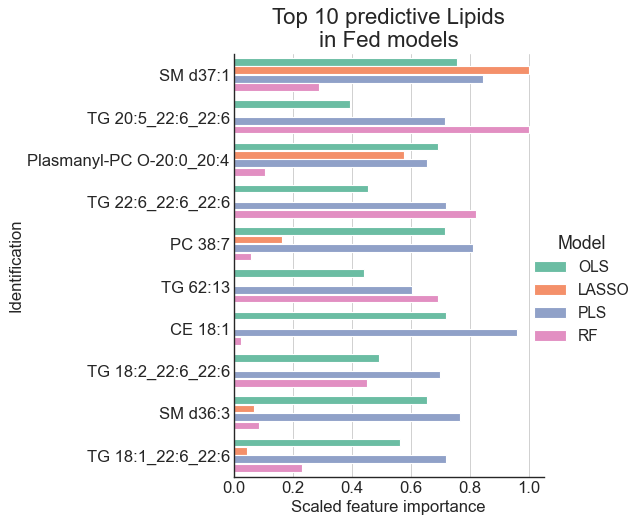

<Figure size 432x288 with 0 Axes>

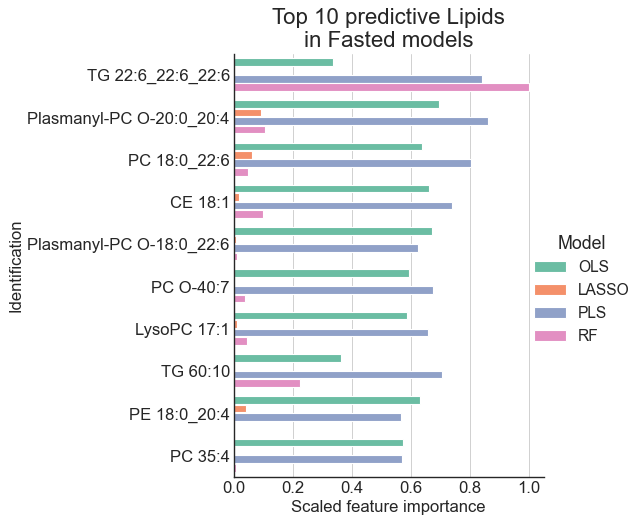

In [206]:
plot_importance(Type='lipid', is_id=True, sampling='Fed', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive Lipids\nin Fed models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fed.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fed.pdf', bbox_inches='tight', dpi=100, facecolor='white')

plt.figure()
plot_importance(Type='lipid', is_id=True, sampling='Fasted', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive Lipids\nin Fasted models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fasted.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_lipids_fasted.pdf', bbox_inches='tight', dpi=100, facecolor='white')


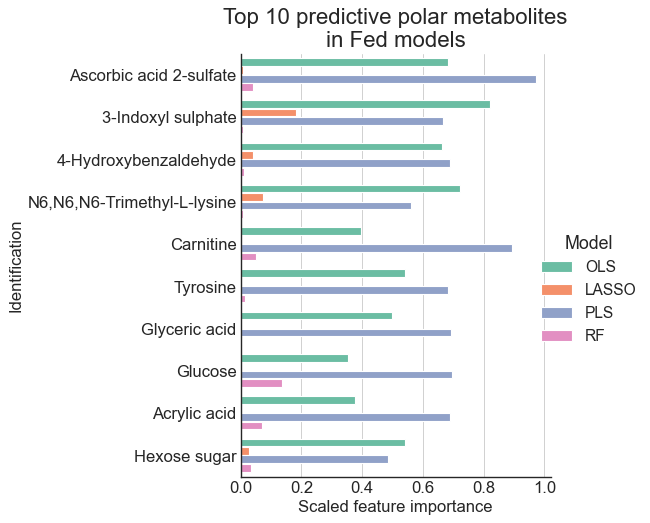

<Figure size 432x288 with 0 Axes>

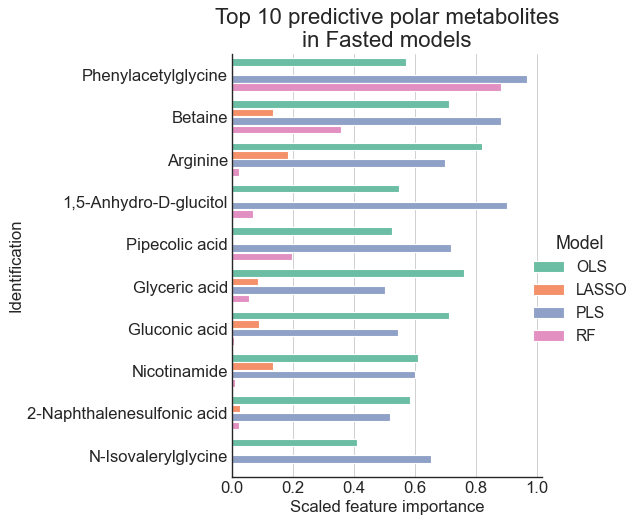

In [207]:
plot_importance(Type='metabolite', is_id=True, sampling='Fed', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive polar metabolites\nin Fed models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fed.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fed.pdf', bbox_inches='tight', dpi=100, facecolor='white')

plt.figure()
plot_importance(Type='metabolite', is_id=True, sampling='Fasted', num_features=10, model_ranking='avg')
plt.title('Top 10 predictive polar metabolites\nin Fasted models', fontsize=20)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fasted.png', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/10_metabs_fasted.pdf', bbox_inches='tight', dpi=100, facecolor='white')


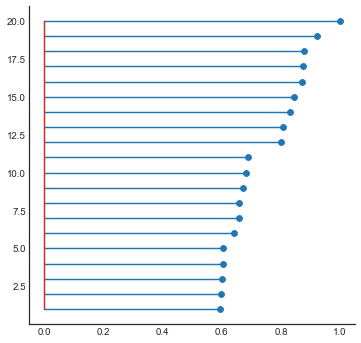

In [68]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=70)

plt.stem(r['y_point'], r['ols_Fed'], orientation='horizontal')
# plt.yticks(ticks=plt.yticks()[0], labels=r['ID'])
sns.despine()

In [46]:
18/291

0.061855670103092786

In [ ]:
plt.stem()

In [25]:
olsfed = r.loc[(r['model'] == 'ols') & (r['x'] == 'Fed')]
olsfed = olsfed[data.index].T.abs().sort_values(0, ascending=False)
olsfed

,0
m_293,146.520210
l_807,139.697373
l_803,125.541193
l_62,121.057603
m_258,120.202456
...,...
m_433,0.208395
l_532,0.205494
l_132,0.171337
l_133,0.121498


In [4]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv')

ranks = r.loc[(r['y'] == 'ogtt') \
              & (~r['model'].isin(['lasso'])),  # Dropping LASSO justifiable because only 251/1371 features 
                                                #    are nonzero, which messes up the rankings 
              data.index].abs().rank(axis=1, ascending=False)
# display(ranks)
avg_rank = ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fed')].mean().sort_values().to_frame('Fed')

avg_rank = avg_rank.join(ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fasted')].mean().to_frame('Fasted'))
avg_rank = avg_rank.join(data[['qval_fed', 'qval_fasted', 'ID']])
avg_rank.loc[:, ['qval_fed', 'qval_fasted']] = avg_rank.loc[:, ['qval_fed', 'qval_fasted']].rank(ascending=True)
ids_ranks = avg_rank.loc[avg_rank['ID'] != 'unknown']
ids_ranks.rename({'Fed': 'Avg. rank fed models', 'Fasted': 'Avg. rank fasted models',
                  'qval_fed': 'Fed linear model rank', 'qval_fasted': 'Fasted linear model rank'}, axis=1, inplace=True)
ids_ranks.iloc[:50]

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Avg. rank fed models,Avg. rank fasted models,Fed linear model rank,Fasted linear model rank,ID
i,,,,,
l_393,18.0,794.8,24.5,1170.5,SM d37:1
l_604,48.2,236.8,12.5,139.0,TG 18:1_22:6_22:6
l_159,51.8,698.0,186.5,852.5,SM d36:3
l_461,51.8,24.4,128.0,35.0,Plasmanyl-PC O-20:0_20:4
l_150,55.6,591.6,449.5,835.0,PC 38:7
l_567,63.2,273.0,9.0,32.0,TG 18:2_22:6_22:6
m_227,70.8,625.2,672.5,1061.0,Ascorbic acid 2-sulfate
l_538,77.2,148.0,7.0,6.0,TG 22:6_22:6_22:6
l_425,80.2,802.8,313.0,1367.5,SM d38:1


In [10]:
data['qval_fed']

i
m_0      0.005399
m_1      0.000001
m_2      0.563218
m_3      0.531078
m_4      0.562464
           ...   
l_868    0.000212
l_869    0.000701
l_870    0.005132
l_871    0.001391
l_872    0.002125
Name: qval_fed, Length: 1371, dtype: float64